## Model Analysis

In [41]:
from importlib import reload
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from model import Transformer, TransformerConfig
from data import get_datasets
from config import base_hparams
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def setup_plot_style():
    # Reset to default style
    plt.style.use('default')
    
    # Make background white
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['figure.facecolor'] = 'white'
    
    # Remove gridlines
    plt.rcParams['axes.grid'] = False
    
    # Make font black and serif
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    
    # Remove top and right spines
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
     
    # Increase x and y axis label size
    plt.rcParams['axes.labelsize'] = 12


# Call this function before creating your plots
setup_plot_style()

In [26]:
# Load the CSV file
df = pd.read_csv('/home/neil/proj/stress_strain/results_20240721_155627.csv')
df = pd.read_csv('/home/neil/proj/stress_strain/results_20240721_163240.csv')
print(f"Loaded {len(df)} rows of data.")

Loaded 15 rows of data.


## 1. Best Hyperparameters

In [27]:
# Find the row with the lowest eval_loss
best_row = df.loc[df['eval_loss'].idxmin()]

# Print the best hyperparameters and corresponding metrics
print("Best Hyperparameters:")
hyperparams = ['num_layers', 'hidden_dim', 'learning_rate', 'dropout_rate', 'total_examples']
for param in hyperparams:
    print(f"{param}: {best_row[param]}")

print(f"\nBest Evaluation Loss: {best_row['eval_loss']:.4f}")
print(f"Step: {best_row['step']}")
print(f"Training Loss: {best_row['train_loss']:.4f}")

Best Hyperparameters:
num_layers: 6
hidden_dim: 16
learning_rate: 0.01
dropout_rate: 0.0
total_examples: 100000

Best Evaluation Loss: 0.0022
Step: 6249
Training Loss: 0.0002


## 2. Hyperparameter Impact Plots

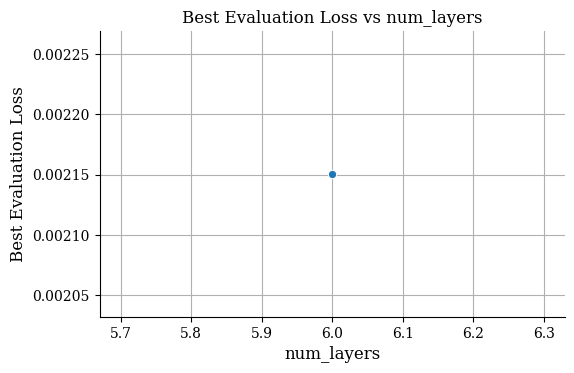

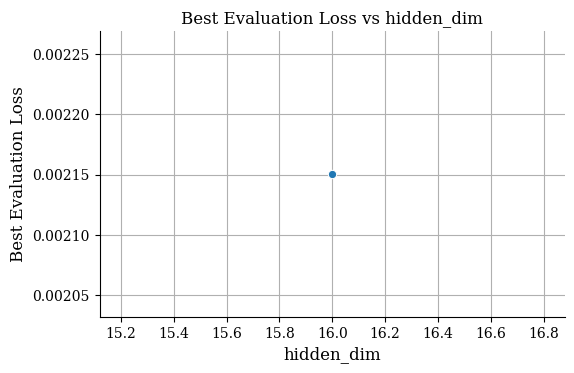

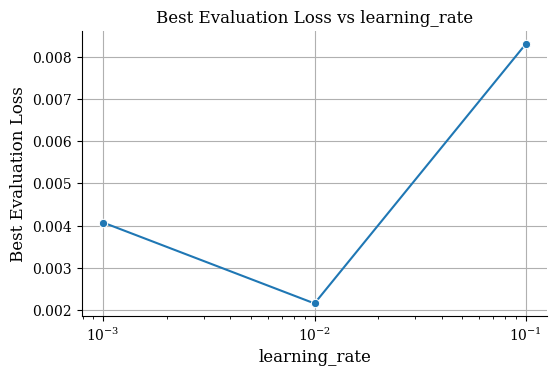

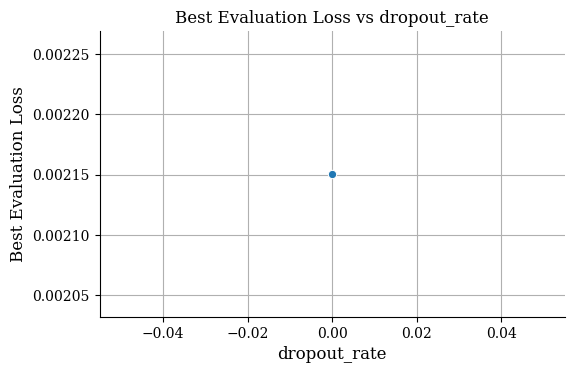

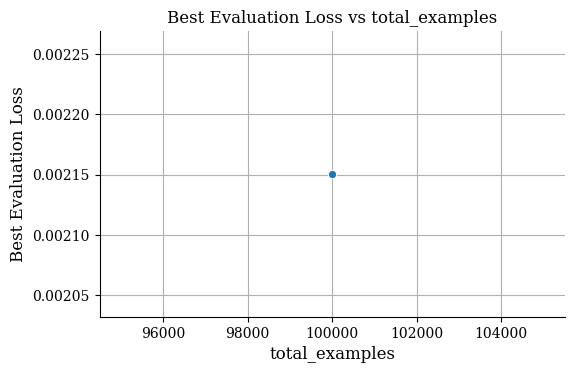

In [28]:
def plot_hyperparam_impact(df, param):
    # Group by the hyperparameter and find the best eval_loss for each value
    grouped = df.groupby(param)['eval_loss'].min().reset_index()
    
    plt.figure(figsize=(6, 6/1.618))
    sns.lineplot(x=param, y='eval_loss', data=grouped, marker='o')
    plt.title(f'Best Evaluation Loss vs {param}')
    plt.xlabel(param)
    plt.ylabel('Best Evaluation Loss')
    if param == 'learning_rate':
        plt.xscale('log')
    plt.grid(True)
    plt.show()

# Plot for each hyperparameter
for param in hyperparams:
    plot_hyperparam_impact(df, param)

In [ ]:
## 4. Run inference and plot

In [42]:
reload(config)
base_hparams = config.base_hparams

def load_model(checkpoint_path):
    # Create a TransformerConfig object with the same parameters as used during training
    config = TransformerConfig(
        max_len=base_hparams["max_len"],
        num_layers=base_hparams["num_layers"],
        hidden_dim=base_hparams["hidden_dim"],
        mlp_dim=base_hparams["mlp_dim"],
        num_heads=base_hparams["num_heads"],
        dropout_rate=base_hparams["dropout_rate"],
        attention_dropout_rate=base_hparams["attention_dropout_rate"],
        causal_x=base_hparams["causal_x"],
        physics_decoder=base_hparams["physics_decoder"],
    )
    
    # Create the model
    model = Transformer(config)
    
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

def run_inference(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_x = []
    all_predictions = []
    all_ground_truth = []
    
    with torch.no_grad():
        for batch in test_loader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            
            predictions, _, _ = model({'x': x})
            
            all_x.append(x.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            all_ground_truth.append(y.cpu().numpy())
    
    return np.concatenate(all_x), np.concatenate(all_predictions), np.concatenate(all_ground_truth)


def plot_predictions(x, predictions, ground_truth, num_samples=5, filename='predictions.pdf'):
    with PdfPages(filename) as pdf:
        for i in range(num_samples):
            fig, ax = plt.subplots(figsize=(12, 6))
            
            ax.plot(x[i, :, 0], ground_truth[i, :, 0], label='Ground Truth')
            ax.plot(x[i, :, 0], predictions[i, :, 0], label='Prediction')
            ax.set_title(f'Sample {i+1}')
            ax.legend()
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)
    
    print(f"Plots saved to {filename}")


# Load the checkpoint
checkpoint_path = "/home/neil/proj/stress_strain/model.pth"  # Update this with your checkpoint path
model = load_model(checkpoint_path)
    
# Get the test dataset
_, test_loader = get_datasets(batch_size=base_hparams["batch_size"])
    
# Run inference
x, predictions, ground_truth = run_inference(model, test_loader)

In [43]:
# Plot the results
plot_predictions(x, predictions, ground_truth, filename='/home/neil/proj/stress_strain/predictions.pdf')

Plots saved to /home/neil/proj/stress_strain/predictions.pdf
